In [8]:
from deap import creator
from deap import base

creator.create("Developer", Employee, position = "Developer",programmingLanguages = set)

# Это равно вот этому 
class Developer(Employee):
    position = "Developer"
    def __init__(self):
        self.programmingLanguages = set()
    
#===========================================
creator.create("FitnessCompound", base.Fitness, weights=(1.0, 0.2, -0.5))

#===========================================
creator.create("Individual", list, fitness=creator.FitnessMax)

#===========================================
def sumOfTwo(a, b):
    return a + b

toolbox= base.Toolbox()
toolbox.register("incrementByFive", sumOfTwo, b=5)

#===========================================
from deap import tools
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.02)

#=========================================== Создание популяции
randomList = tools.initRepeat(list, random.random, 30)

toolbox.register("zeroOrOne", random.randint, 0, 1)
randomList = tools.initRepeat(list, toolbox.zeroOrOne, 30) # первое-контейнер для заполнения, второе-функция, третье-сколько раз сгенерировать

#=========================================== Вычисление приспособленности
def someFitnessCalculationFunction(individual):
    return _some_calculation_of_the_fitness

toolbox.register("evaluate",someFitnessCalculationFunction)

# Задача ONE_MAX (подготовка)

In [1]:
# Задача: максимальная сумма двоичной хромосомы размером 5
# 1) выбор хромосомы - ответ: двоичная хромосома размером 5, то есть, например [1,0,0,1,0]
# 2) функция приспособленности - обычная сумма: sum([1, 0, 0, 1,0]) = 2.
# 3) выбор операторов: отбор-турнир, скрещивание-одноточечное/двухточечное, мутация-инвертирование
# 4) выбор условия остановки - хромосома, где все единицы, ограничение поколений

from deap import base
from deap import creator
from deap import tools
import random
import matplotlib.pyplot as plt

#=========================================== Константы
# константы задачи
ONE_MAX_LENGTH = 100 # длина подлежащей оптимизации битовой строки

# константы генетического алгоритма
POPULATION_SIZE = 200 # количество индивидуумов в популяции
P_CROSSOVER = 0.9 # вероятность скрещивания
P_MUTATION = 0.1 # вероятность мутации индивидуума
MAX_GENERATIONS = 50 # максимальное количество поколений

RANDOM_SEED = 42
random.seed(RANDOM_SEED) # на этапе эксперементирования для воспроизводимости

#=========================================== 
toolbox = base.Toolbox()
toolbox.register("zeroOrOne", random.randint, 0, 1)

#=========================================== Создание класса Fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # цель-сумма цифр, задача-максимизировать сумму

#=========================================== Создание класса Individual, хромосома-список 
creator.create("Individual", list, fitness=creator.FitnessMax)

#=========================================== генератор индивидуумов
# Поскольку оператор zeroOrOne создает объекты, принимающие случайное значение 0 или 1,
# то получающийся в результате оператор individualCreator заполняет экземпляр Individual 100 случайными значениями 0 или 1

toolbox.register("individualCreator", 
                 tools.initRepeat, 
                 creator.Individual, 
                 toolbox.zeroOrOne, 
                 ONE_MAX_LENGTH)

#=========================================== генератор популяции
toolbox.register("populationCreator",
                 tools.initRepeat,
                 list, 
                 toolbox.individualCreator) # количество повторений мы потом зададим свми вручную

#=========================================== вычисление приспособленности
# в нашем случае просто сумма
def oneMaxFitness(individual):
    return sum(individual), # Здесь ЗАПЯТАЯ, чтобы был кортеж

# как уже было сказано, значения приспособленности в DEAP представлены кортежами, 
# поэтому если возвращается всего одно значение, то после него нужно поставить запятую

#=========================================== определяем параметр evaluate()
toolbox.register("evaluate", oneMaxFitness)

#=========================================== инстранцирование ген операторов
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/ONE_MAX_LENGTH)

# Обратите внимание на параметр indpb функции mutFlipBit. Эта функция обходит все атрибуты индивидуума 
# – в нашем случае список значений 0 и  1 – и для каждого атрибута использует значение данного 
# аргумента как вероятность инвертирования (применения логического 
# оператора НЕ) значения атрибута. Это значение не зависит от вероятности мутации, 
# которая задается константой P_MUTATION, – мы определили ее выше, но пока не использовали. Вероятность мутации нужна 
# при решении о том, вызывать ли функцию mutFlipBit для данного индивидуума в популяции

# Задача ONE_MAX (решение)

In [2]:
#=========================================== создаём начальную популяцию
population = toolbox.populationCreator(n=POPULATION_SIZE) # вот как раз задали вручную
generationCounter = 0

#=========================================== вычисление приспособленности каждого индивидуума в популяции
fitnessValues = list(map(toolbox.evaluate, population))

#===========================================
for individual, fitnessValue in zip(population, fitnessValues):
    individual.fitness.values = fitnessValue

#=========================================== извлекаем приспособленности
fitnessValues = [individual.fitness.values[0] for individual in population]

#=========================================== создаём два списка, что считать макс и сред приспомобленность в каждом поколении
maxFitnessValues = []
meanFitnessValues = []

#=========================================== цикл, чтобы проверять условия остановки
while max(fitnessValues) < ONE_MAX_LENGTH and generationCounter< MAX_GENERATIONS:
    generationCounter = generationCounter + 1
    
    offspring = toolbox.select(population, len(population)) # отбор
    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]): # скрещивание
         if random.random() < P_CROSSOVER:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
            
    for mutant in offspring: # мутация
        if random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values

#=========================================== 
# пересчитываем приспособленность тем, кого обнулили, valid-те,
# у кого осталась старая приспособленность-те, кто не скрещивался и не мутировал     
    freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
    freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
    for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
        individual.fitness.values = fitnessValue
            
#=========================================== Замена старой популяции новой           
    population[:] = offspring

#=========================================== учитываем все новые приспособленности и старые
    fitnessValues = [ind.fitness.values[0] for ind in population]

#=========================================== помещаем данные в накопители, выводим статистику
    maxFitness = max(fitnessValues)
    meanFitness = sum(fitnessValues) / len(population)
    maxFitnessValues.append(maxFitness)
    meanFitnessValues.append(meanFitness)
    print("- Поколение {}: Макс приспособ. = {}, Средняя приспособ. = {}".format(generationCounter, maxFitness, meanFitness))

#=========================================== попутно находим лучшего индивидуума и печатаем его 
    best_index = fitnessValues.index(max(fitnessValues))
    print("Лучший индивидуум = ", *population[best_index], "\n")

- Поколение 1: Макс приспособ. = 65.0, Средняя приспособ. = 53.575
Лучший индивидуум =  1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 

- Поколение 2: Макс приспособ. = 66.0, Средняя приспособ. = 56.855
Лучший индивидуум =  1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 

- Поколение 3: Макс приспособ. = 69.0, Средняя приспособ. = 59.42
Лучший индивидуум =  1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 

- Поколение 4: Макс приспособ. = 70.0, Средняя приспособ. = 62.03
Лучший индивидуум =  1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 

- Поколение 32: Макс приспособ. = 97.0, Средняя приспособ. = 95.93
Лучший индивидуум =  1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

- Поколение 33: Макс приспособ. = 97.0, Средняя приспособ. = 96.085
Лучший индивидуум =  1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 

- Поколение 34: Макс приспособ. = 98.0, Средняя приспособ. = 96.325
Лучший индивидуум =  1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

- Поколение 35: Макс приспособ. = 98.0, Средняя приспособ. = 96.835
Лучший индивидуум =  1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1

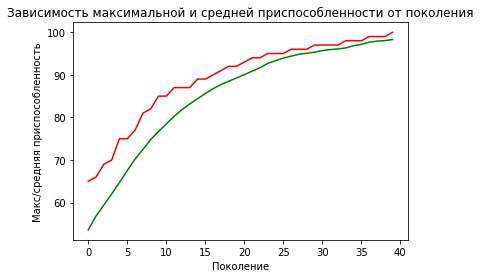

In [14]:
import matplotlib.pyplot as plt
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
plt.show()

# Задача ONE_MAX лаконичный вид

In [6]:
import numpy as np
from deap import algorithms

#=========================================== создаём популяцию, однако тулбокс переписывать не будем-он уже определён
population = toolbox.populationCreator(n=POPULATION_SIZE)

#=========================================== регистрируем то, как будем собирать статистику
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

#=========================================== Создаём зал славы
HALL_OF_FAME_SIZE = 10 #количество индивидуумов, которые будут храниться в зале славы
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

#=========================================== eaSimple
# Метод algorithms.eaSimple предполагает, что в toolbox уже зарегистрированы операторы evaluate, 
# select, mate и mutate, – и мы действительно сделали это в первоначальной версии программы

population, logbook = algorithms.eaSimple(population, # Здесь population - конечная популяция
                                          toolbox,                                        
                                          cxpb=P_CROSSOVER,
                                          mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS,
                                          stats=stats,
                                          halloffame=hof,
                                          verbose=True) # verbose=True, значит будет выведена статистика

#=========================================== Извлечение статистики
maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

print(maxFitnessValues, meanFitnessValues)

print("Индивидуумы в зале славы = ", *hof.items, sep="\n")
print("Лучший индивидуум = ", hof.items[0]) # в начале самый лучший

gen	nevals	max	avg   
0  	200   	65 	50.095
1  	170   	66 	54.89 
2  	183   	69 	58.37 
3  	180   	72 	61.485
4  	174   	74 	64.405
5  	196   	75 	67.6  
6  	190   	76 	70.21 
7  	175   	78 	72.41 
8  	187   	80 	74.34 
9  	175   	81 	75.88 
10 	181   	83 	77.32 
11 	186   	83 	78.855
12 	184   	86 	80.32 
13 	185   	86 	81.625
14 	189   	86 	82.85 
15 	185   	88 	84.27 
16 	180   	89 	85.33 
17 	177   	90 	86.3  
18 	172   	92 	87.26 
19 	186   	92 	88.205
20 	183   	93 	89.37 
21 	187   	94 	90.47 
22 	176   	95 	91.46 
23 	184   	95 	92.425
24 	175   	96 	93.175
25 	188   	97 	93.865
26 	185   	97 	94.505
27 	184   	97 	95.2  
28 	191   	97 	95.845
29 	176   	98 	96.485
30 	181   	98 	96.825
31 	190   	99 	96.99 
32 	173   	99 	97.32 
33 	186   	99 	97.755
34 	176   	99 	98.12 
35 	187   	99 	98.49 
36 	184   	100	98.775
37 	176   	100	98.92 
38 	185   	100	98.97 
39 	187   	100	99.08 
40 	183   	100	99.305
41 	174   	100	99.655
42 	186   	100	99.91 
43 	179   	100	99.86 
44 	185   

# Типичное поведение всех ген алгоритмов:

1) С увеличением популяции возрастает скорость нахождения лучшего решения, и требуется меньше поколений,
однако мощностей нужно больше
2) С двухточечное скрещивание быстрее помогает найти решение, чем одноточечное (при двоичных хромосомах)
3) При увеличения вероятностей мутации (как P_MUTATION, так и indpb) прогресс становится спорадическим, чем сильнее
мутация тем больше это похоже на случайный поиск
4) При увеличении турнира (при отборе) повышается вероятность преждевременной сходимости, в таких условиях помогает только мутация, чтобы популяция двинулась в нужную сторону
5) При использовании рулетки (при отборе) у слабых появляется шанс переходить в другие поколения и появляется риск, что правильные решения забудутся, здесь поможет элитизм


# Задача рюкзак 1-0

gen	nevals	max	avg   
0  	50    	785	574.78
1  	45    	870	669.78
2  	46    	880	764.64
3  	46    	965	812.4 
4  	44    	995	884.34
5  	46    	1030	912.48
6  	41    	995 	948.1 
7  	44    	995 	965.44
8  	44    	1000	965.54
9  	46    	1000	968.44
10 	46    	1000	983.6 
11 	42    	1000	988.8 
12 	48    	1000	989.74
13 	44    	1000	987.5 
14 	47    	1000	990.1 
15 	43    	1000	992.2 
16 	39    	1000	997.4 
17 	48    	1000	995.5 
18 	38    	1000	993.6 
19 	46    	1000	981.7 
20 	48    	1000	1000  
21 	45    	1000	992.1 
22 	44    	1000	991.4 
23 	46    	1000	993.54
24 	50    	1000	993.9 
25 	50    	1000	993.6 
26 	46    	1000	979.4 
27 	50    	1000	991.5 
28 	50    	1000	996.04
29 	44    	1000	988.2 
30 	47    	1000	992.8 
31 	48    	1000	1000  
32 	46    	1000	996.3 
33 	46    	1030	993.7 
34 	46    	1030	990.8 
35 	46    	1030	996.1 
36 	50    	1030	996.9 
37 	47    	1030	996.2 
38 	40    	1030	1003.1
39 	48    	1030	1015.3
40 	46    	1030	1025.3
41 	48    	1030	1024.5
42 	46    	1030	1

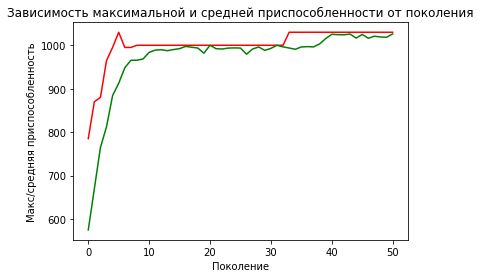

In [14]:
import knapsack
from deap import base
from deap import creator
from deap import tools
import random
import matplotlib.pyplot as plt
from deap import algorithms
import numpy as np

toolbox = base.Toolbox()

#=========================================== экземпляр задачи из библиотеки
knapsack = knapsack.Knapsack01Problem()

#=========================================== в функцию evoluate записываем функцию нахождения ценности 
# (она же считает вес, но ретурнит только ценность)
def knapsackValue(individual):
    return knapsack.getValue(individual),
toolbox.register("evaluate", knapsackValue)

#=========================================== регистрируем операторы отбора, скрещивания, мутации
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/len(knapsack))

#=========================================== компиляция модели
ONE_MAX_LENGTH = 22
P_CROSSOVER=0.9
P_MUTATION=0.1
MAX_GENERATIONS=50
HALL_OF_FAME_SIZE = 10
POPULATION_SIZE=50

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

toolbox.register("zeroOrOne", random.randint, 0, 1)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
 
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox.register("individualCreator", 
                 tools.initRepeat, 
                 creator.Individual, 
                 toolbox.zeroOrOne, 
                 ONE_MAX_LENGTH)

toolbox.register("populationCreator",
                 tools.initRepeat,
                 list, 
                 toolbox.individualCreator)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

population = toolbox.populationCreator(n=POPULATION_SIZE)

population, logbook = algorithms.eaSimple(population, # Здесь population в ретурне - конечная популяция
                                          toolbox,                                        
                                          cxpb=P_CROSSOVER,
                                          mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS,
                                          halloffame=hof,
                                          stats=stats,
                                          verbose=True) 

maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

best = hof.items[0]
print("-- Предметы в рюкзаке = ")
knapsack.printItems(best)

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
plt.show()

# Задача коммивояжера

Описание:
Нужно объехать 29 городов баварии и вернутся туда, где начал. Пройденное расстояние в итоге должно получиться минимальным.

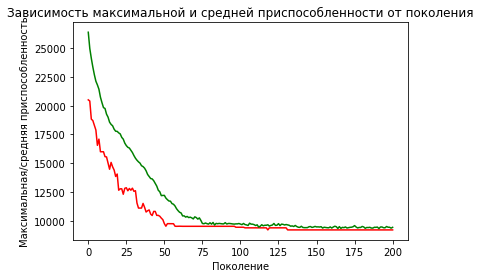

Лучший маршрут: Individual('i', [14, 3, 12, 9, 19, 1, 20, 28, 2, 25, 4, 8, 11, 5, 27, 0, 23, 15, 26, 7, 22, 6, 24, 18, 10, 13, 21, 16, 17]).
{'gen': 200, 'nevals': 291, 'min': 9207.763671875, 'avg': 9432.18939453125}


In [11]:
import tsp
from deap import base
from deap import creator
from deap import tools
import random
import matplotlib.pyplot as plt
from deap import algorithms
import numpy as np
import array

toolbox = base.Toolbox()

TSP_NAME = "bayg29"
tsp = tsp.TravelingSalesmanProblem(TSP_NAME)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # минимизируем расстояние

creator.create("Individual", 
               array.array, 
               typecode='i',# целое число со знаком, размер которого составляет 2 байта
               fitness=creator.FitnessMin) 

toolbox.register("randomOrder", 
                 random.sample, 
                 range(len(tsp)),
                 len(tsp))

toolbox.register("individualCreator", 
                 tools.initIterate,
                 creator.Individual,
                 toolbox.randomOrder)

toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list,
                 toolbox.individualCreator)

def tpsDistance(individual):
    return tsp.getTotalDistance(individual), # return a tuple
toolbox.register("evaluate", tpsDistance)

# потому что у нас список индексов-порядок посещения городов, соответственно и срещивание должно быть упорядоченное
toolbox.register('select',tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOrdered) 
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(tsp))

P_CROSSOVER = 0.9
P_MUTATION = 0.1
MAX_GENERATIONS = 200

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

hof = tools.HallOfFame(10)

population = toolbox.populationCreator(n=300)

population, logbook = algorithms.eaSimple(population, 
                                          toolbox,
                                          cxpb=P_CROSSOVER,
                                          mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS,
                                          stats=stats,
                                          halloffame=hof,
                                          verbose=False)

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Максимальная/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
plt.show()

best = hof.items[0]
print(f'Лучший маршрут: {best}.')
print(logbook[-1])

# Элитизм для задачи коммивояжера

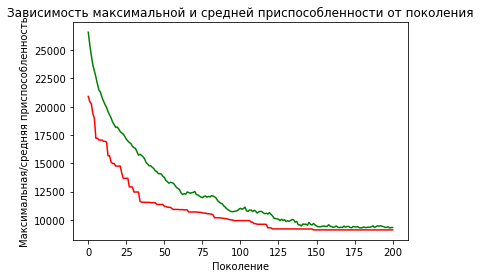

Лучший маршрут: Individual('i', [21, 10, 18, 24, 6, 22, 7, 26, 15, 23, 0, 27, 5, 11, 8, 4, 25, 2, 28, 20, 1, 19, 9, 12, 3, 14, 17, 13, 16]).
{'gen': 200, 'nevals': 241, 'min': 9111.6083984375, 'avg': 9325.678359375}


In [10]:
import elitism
import tsp
from deap import base
from deap import creator
from deap import tools
import random
import matplotlib.pyplot as plt
from deap import algorithms
import numpy as np
import array

toolbox = base.Toolbox()

TSP_NAME = "bayg29"
tsp = tsp.TravelingSalesmanProblem(TSP_NAME)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # минимизируем расстояние

creator.create("Individual", 
               array.array, 
               typecode='i',# целое число со знаком, размер которого составляет 2 байта
               fitness=creator.FitnessMin) 

toolbox.register("randomOrder", 
                 random.sample, 
                 range(len(tsp)),
                 len(tsp))

toolbox.register("individualCreator", 
                 tools.initIterate,
                 creator.Individual,
                 toolbox.randomOrder)

toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list,
                 toolbox.individualCreator)

def tpsDistance(individual):
    return tsp.getTotalDistance(individual), # return a tuple
toolbox.register("evaluate", tpsDistance)

# потому что у нас список индексов-порядок посещения городов, соответственно и срещивание должно быть упорядоченное
toolbox.register('select',tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxOrdered) 
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(tsp))

P_CROSSOVER = 0.9
P_MUTATION = 0.1
MAX_GENERATIONS = 200

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

hof = tools.HallOfFame(30) # 30 лучших индивидуумов пойдут в следующее поколение (элитизм)

population = toolbox.populationCreator(n=300)

population, logbook = elitism.eaSimpleWithElitism(population, 
                                          toolbox,
                                          cxpb=P_CROSSOVER,
                                          mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS,
                                          stats=stats,
                                          halloffame=hof,
                                          verbose=False)

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Максимальная/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
plt.show()

best = hof.items[0]
print(f'Лучший маршрут: {best}.')
print(logbook[-1])